In [12]:
import sys
import os

path = os.path.abspath("./DeepLearningTest")
if path not in sys.path:
    sys.path.append(path)

import time
import torch
import common

torch.set_default_dtype(torch.float32)

In [13]:
@torch.jit.script
def calc_polynomial(x, cs):
    y = torch.zeros_like(x)
    last_x = torch.ones_like(x)
    for c in cs:
        y += c * last_x
        last_x = last_x * x
    return y


class Polynomial(torch.nn.Module):
    def __init__(self, degree, init=lambda d: torch.zeros(d)):
        super(Polynomial, self).__init__()
        self.coefficients = torch.nn.Parameter(init(degree))

    def forward(self, x):
        return calc_polynomial(x, self.coefficients)


class PolynomialWithSigmoid(torch.nn.Module):
    def __init__(self, degree, init=lambda d: torch.zeros(d)):
        super(PolynomialWithSigmoid, self).__init__()
        self.polynomial = Polynomial(degree, init)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.polynomial(x))


class RationalPolynomial(torch.nn.Module):
    def __init__(self, degree):
        super(RationalPolynomial, self).__init__()
        self.a = Polynomial(degree, lambda d: torch.rand(d) * 2 - 1)
        self.b = Polynomial(degree, lambda d: torch.rand(d) * 2 - 1)

    def forward(self, x):
        return self.a(x) / self.b(x)


class RationalPolynomialWithSigmoid(torch.nn.Module):
    def __init__(self, degree):
        super(RationalPolynomialWithSigmoid, self).__init__()
        self.a = Polynomial(degree, lambda d: torch.rand(d) * 2 - 1)
        self.b = Polynomial(degree, lambda d: torch.rand(d) * 2 - 1)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.a(x) / self.b(x))

In [18]:
def run_test_print_result(parameter, runs):

    def run():
        network = common.NeuralNetwork(2, 1, parameter.hidden_layers, parameter.layer_size, parameter.activation_func)
        optimizer = torch.optim.Adam(network.parameters(), lr=parameter.lr, betas=parameter.betas, eps=parameter.eps, weight_decay=parameter.weight_decay)

        def loss(y_pred, y):
            return ((y_pred - y) ** 2) * (y * len(y) + (1 - y))

        ix = parameter.test_data.n / 2
        iy = parameter.test_data.n / 2
        i = int(parameter.test_data.n * iy + ix)
        return common.run_test_with_network_full_result(network, optimizer, loss, parameter.test_data.X, parameter.test_data.Ys[i], i, parameter.max_epoch)

    total_result = None

    start_time = time.time_ns()

    for i in range(runs):
        result = run()
        if total_result == None:
            total_result = result
        else:
            total_result.epoch_loss_y += result.epoch_loss_y
            total_result.y_pred += result.y_pred

    print("{:.2f} ms/run".format((time.time_ns() - start_time) / runs / 1_000_000.0))

    total_result.epoch_loss_y /= runs
    total_result.y_pred /= runs

    total_result.plot_epoch_loss()
    total_result.plot_pred_grid()


In [15]:
dataset_n = 20
test_data = common.TestData(dataset_n)

def test_parameter(activation_func):
    return common.TestParameter(
        hidden_layers=hidden_layers,
        layer_size=layer_size,
        activation_func=activation_func,
        max_epoch=max_epoch,
        lr=lr,
        betas=betas,
        eps=eps,
        weight_decay=weight_decay,
        test_data=test_data
    )

# The bad one

Normal polynomial and normal rational polynomial

100.07 ms/run


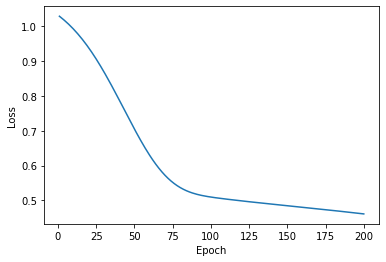

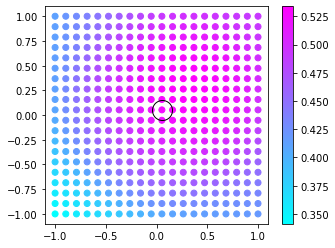

147.65 ms/run


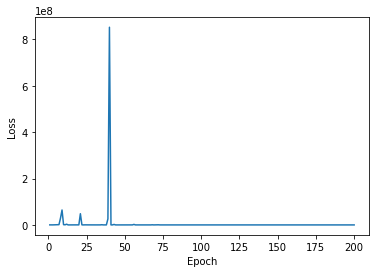

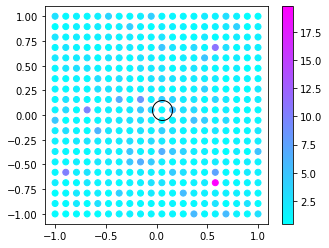

In [11]:
hidden_layers = 1
layer_size = 32

max_epoch = 200
lr = 0.001
betas = (0.9, 0.99)
eps = 0.000_0001
weight_decay = 0.0

run_test_print_result(test_parameter(lambda: Polynomial(3)), 100)
run_test_print_result(test_parameter(lambda: RationalPolynomial(3)), 100)

# The good one

Polynomial w/ sigmoid

#### 3rd degree / Quadratic

In [19]:
hidden_layers = 1
layer_size = 32

lr = 0.1
betas = (0.9, 0.99)
eps = 0.000_0001
weight_decay = 0.0

35.34 ms/run


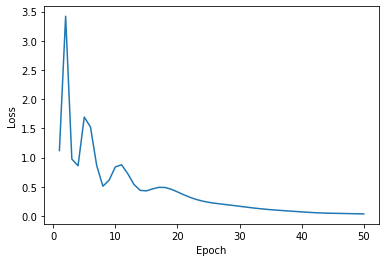

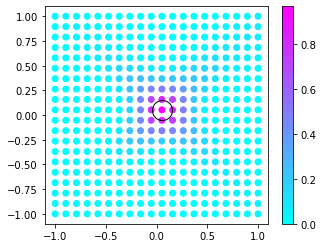

In [20]:
max_epoch = 50

run_test_print_result(test_parameter(lambda: PolynomialWithSigmoid(3)), 100)

57.66 ms/run


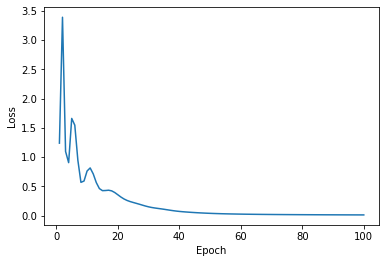

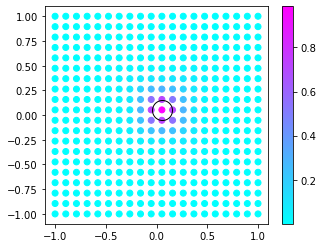

In [8]:
max_epoch = 100

run_test_print_result(test_parameter(lambda: PolynomialWithSigmoid(3)), 100)

#### 32th degree

In [9]:
hidden_layers = 1
layer_size = 32

lr = 0.05
betas = (0.9, 0.99)
eps = 0.000_0001
weight_decay = 0.0

156.29 ms/run


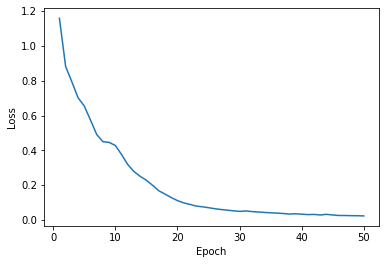

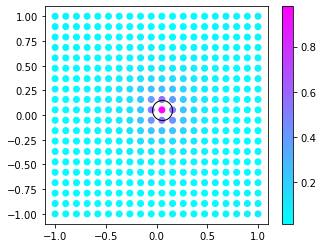

In [10]:
max_epoch = 50

run_test_print_result(test_parameter(lambda: PolynomialWithSigmoid(32)), 100)

269.85 ms/run


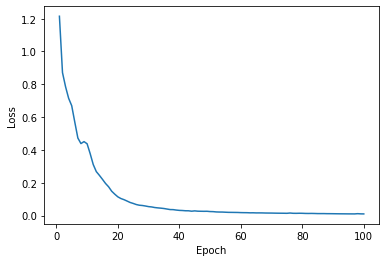

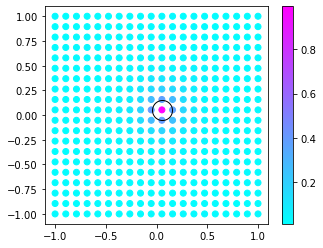

In [11]:
max_epoch = 100

run_test_print_result(test_parameter(lambda: PolynomialWithSigmoid(32)), 100)

# The ok? one
Rational polynomial w/ sigmoid

41.35 ms/run


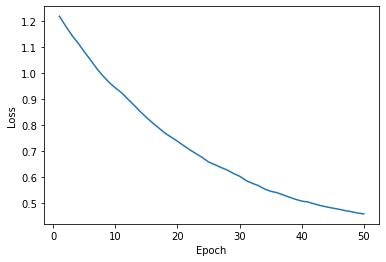

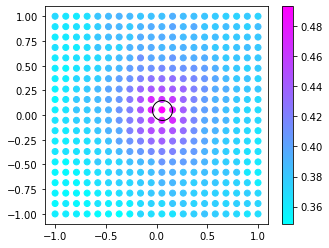

In [10]:
hidden_layers = 1
layer_size = 32

max_epoch = 50
lr = 0.001
betas = (0.9, 0.99)
eps = 0.000_0001
weight_decay = 0.01

run_test_print_result(test_parameter(lambda: RationalPolynomialWithSigmoid(3)), 100)

35.95 ms/run


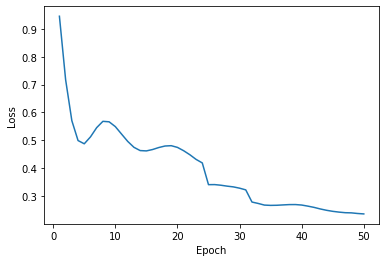

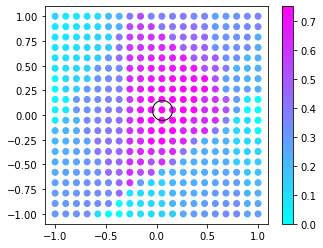

35.71 ms/run


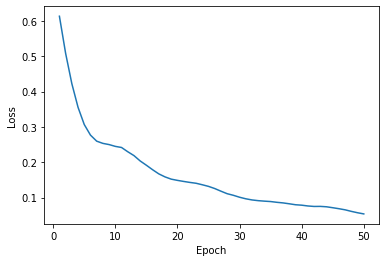

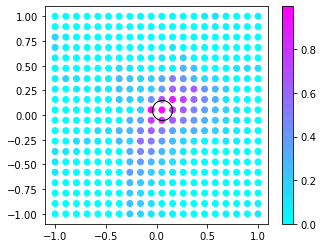

30.65 ms/run


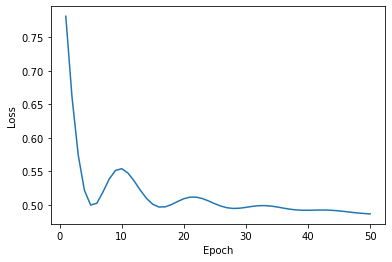

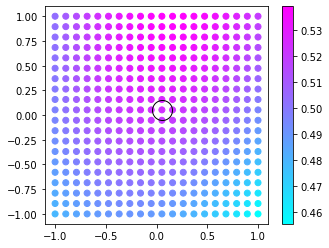

In [13]:
for i in range(3):
    run_test_print_result(test_parameter(lambda: RationalPolynomialWithSigmoid(3)), 1)

# The normal ones
ReLU and sigmoid

In [14]:
hidden_layers = 1
layer_size = 32

lr = 0.1
betas = (0.9, 0.99)
eps = 0.000_000_1
weight_decay = 0.0

14.07 ms/run


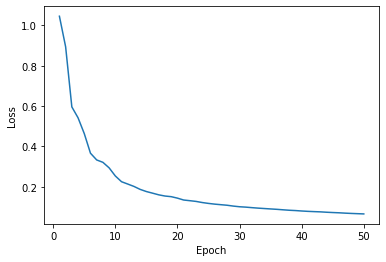

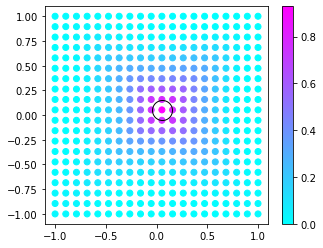

14.48 ms/run


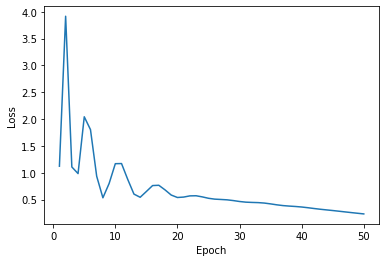

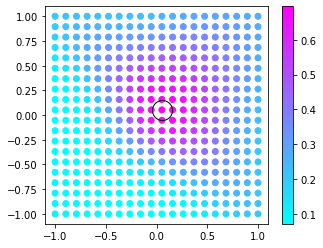

In [15]:
max_epoch = 50

run_test_print_result(test_parameter(torch.nn.ReLU), 100)
run_test_print_result(test_parameter(torch.nn.Sigmoid), 100)

60.56 ms/run


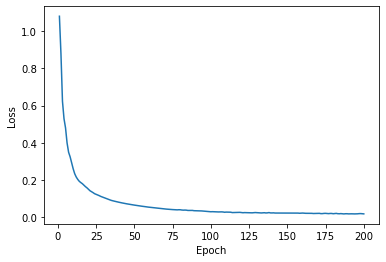

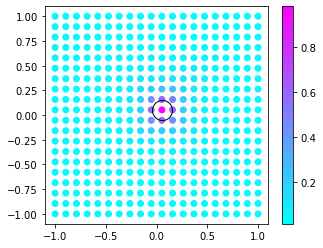

69.25 ms/run


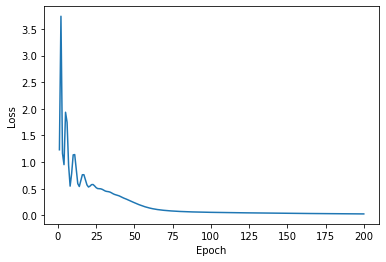

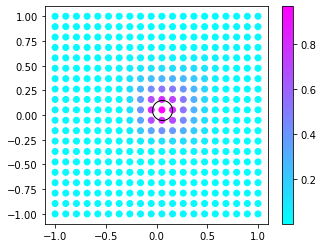

In [18]:
max_epoch = 100

run_test_print_result(test_parameter(torch.nn.ReLU), 100)
run_test_print_result(test_parameter(torch.nn.Sigmoid), 100)

In [26]:
hidden_layers = 1
layer_size = 32

lr = 0.1
betas = (0.9, 0.99)
eps = 0.000_000_1
weight_decay = 0.0

max_epoch = 200

def run_test_print_result(parameter, runs, ix, iy):

    def run():
        network = common.NeuralNetwork(2, 1, parameter.hidden_layers, parameter.layer_size, parameter.activation_func)
        optimizer = torch.optim.Adam(network.parameters(), lr=parameter.lr, betas=parameter.betas, eps=parameter.eps, weight_decay=parameter.weight_decay)

        def loss(y_pred, y):
            return ((y_pred - y) ** 2) * (y * len(y) + (1 - y))

        i = int(parameter.test_data.n * iy + ix)
        return common.run_test_with_network_full_result(network, optimizer, loss, parameter.test_data.X, parameter.test_data.Ys[i], i, parameter.max_epoch)

    total_result = None

    start_time = time.time_ns()

    for i in range(runs):
        result = run()
        if total_result == None:
            total_result = result
        else:
            total_result.epoch_loss_y += result.epoch_loss_y
            total_result.y_pred += result.y_pred

    print("{:.2f} ms/run".format((time.time_ns() - start_time) / runs / 1_000_000.0))

    total_result.epoch_loss_y /= runs
    total_result.y_pred /= runs

    total_result.plot_pred_grid()

122.66 ms/run


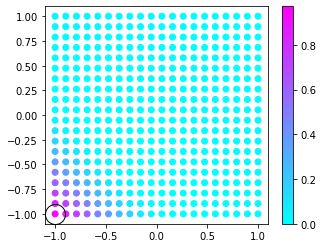

In [27]:
run_test_print_result(test_parameter(torch.nn.Sigmoid), 10, 0, 0)

111.53 ms/run


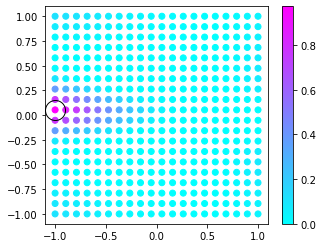

In [33]:
run_test_print_result(test_parameter(torch.nn.Sigmoid), 10, 0, 10)

110.02 ms/run


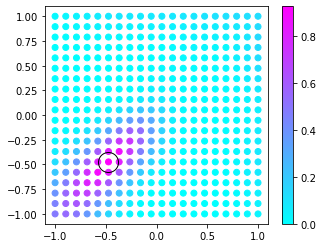

In [32]:
run_test_print_result(test_parameter(torch.nn.Sigmoid), 10, 5, 5)

85.45 ms/run


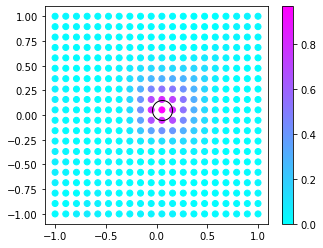

In [36]:
run_test_print_result(test_parameter(torch.nn.Sigmoid), 10, 10, 10)

107.40 ms/run


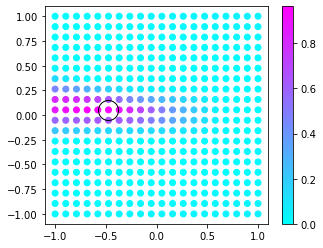

In [39]:
run_test_print_result(test_parameter(torch.nn.Sigmoid), 10, 5, 10)